/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model doesn't converge on raw data in 100 iterations.
Therefore we will preprocess the data, step by step, and compare model performance. 
Pre-process step 1 - Scaling.
Result - Model converges! But how does it perform?
roc auc score= 0.7557227363696769 (OK)
f1 score= 0.6730769230769231 (Poor, needs resampling.)
Precision score= 0.6928838951310862 (Around 50 percent predicted default cases are false)
Recall score 0.6543708943911066 (More than 90 percent non-default cases are actually default, very risky to detect defaults)
Model needs significant improvement.
Calculating interpretability of features..


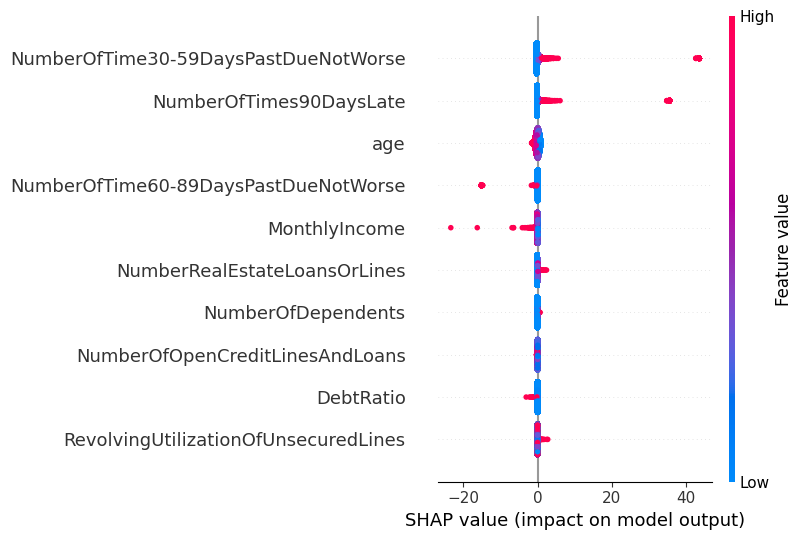

Conclusion: Highest contributing features to non-default: NumberOfTime60-89DaysPastDueNotWorse (Does NOT make sense),MonthlyIncome (Makes sense.)
Highest contributing features to default: NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate (Makes sense.)
We examine feature-multicollinearity to understand why the SHAP values indicate that the high value of NumberOfTime60-89DaysPastDueNotWorse causes non-default.
Examining multicollinearity..
VIF Table
                               features      values
0  RevolvingUtilizationOfUnsecuredLines    1.003749
1                                   age    1.095892
2  NumberOfTime30-59DaysPastDueNotWorse   69.348798
3                             DebtRatio    1.057374
4                         MonthlyIncome    1.041994
5       NumberOfOpenCreditLinesAndLoans    1.385895
6               NumberOfTimes90DaysLate   83.527289
7          NumberRealEstateLoansOrLines    1.345795
8  NumberOfTime60-89DaysPastDueNotWorse  119.212042
9              

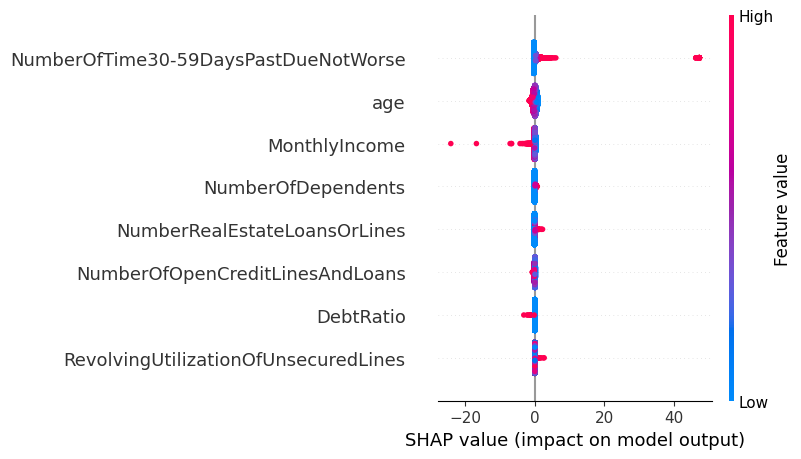

conclusion from shap values after dropping redundant features: Wrong directions removed, no high correlation visible
Re-examining roc_auc_score and f1 score after dropping redundant features:
roc auc score= 0.7305867613882777 (still OK)
f1 score= 0.6571282575370465 (still very Poor, so we'll now do resampling.)
Precision before resampling: 0.6645994832041343
Recall before resampling: 0.6498231430015159
roc auc score after resampling = 0.7295277828617809 (Better)
f1 score after resampling= 0.6501278772378517 (Huge improvement)
Precision after resampling: 0.6582081822889695 (Better)
Recall after resampling: 0.6422435573521981 (Huge improvement)
conclusion: resampling improves roc_auc_score & precision score, and hugely improved f1 & recall scores, thus the model's capacity to minimize both false negatives and false positives,
and thus minimize the chances for both wrongly denying loans and approving risky loans.
                    Stage / Step  ROC AUC Score  F1 Score  Precision  Recall

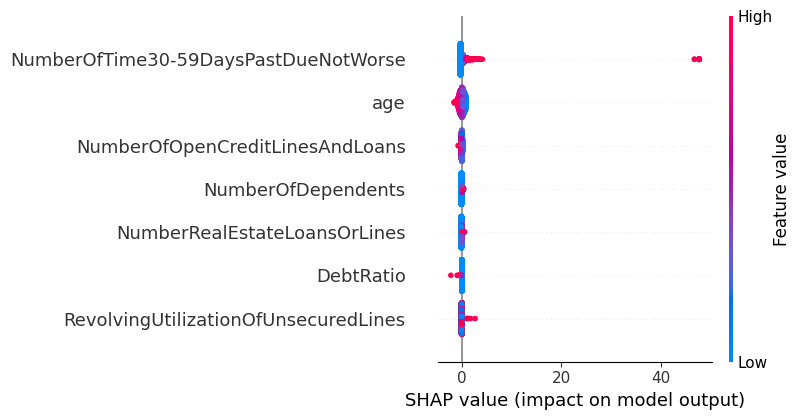

In [348]:
import numpy as np
import pandas as pd
from pathlib import Path
# 1. Load data
script_dir = Path().resolve()
train_file = script_dir / "cs-training.csv"
train_df = pd.read_csv(train_file)

# 2a. Data cleaning step 1 (handle NaNs) outliers)
train_df.drop(columns="Unnamed: 0",inplace=True)
train_df.isna().mean().sort_values(ascending=False)
train_df.dropna(subset="SeriousDlqin2yrs",inplace=True)

train_df['SeriousDlqin2yrs'].value_counts()

# 1. Separate the classes
df2 = train_df.copy()
df_majority = df2[df2.SeriousDlqin2yrs == 0]
df_minority = df2[df2.SeriousDlqin2yrs == 1]

# 2. Downsample majority class
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# 3. Combine balanced dataset
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# 4. Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

train_df=df_balanced.copy()
#print("majority=",df_majority)
#print("minority=",df_minority)

# 2b. Data cleaning step 1 (Impute missing values)
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy="median")
train_df["MonthlyIncome"]=imputer.fit_transform(train_df[["MonthlyIncome"]])
train_df["NumberOfDependents"]=imputer.fit_transform(train_df[["NumberOfDependents"]])
X_raw=train_df.drop(columns="SeriousDlqin2yrs")
y_raw=train_df["SeriousDlqin2yrs"]

# 3 A. Fit Logistic Regression model on raw data
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=100)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_raw,y_raw,test_size=0.2,random_state=42)
model.fit(X_train,y_train)
ypred=model.predict(X_test)
yprob=model.predict_proba(X_test)[:,1]
print("model doesn't converge on raw data in 100 iterations.")
print("Therefore we will preprocess the data, step by step, and compare model performance. ")
print("Pre-process step 1 - Scaling.")
# 3 B. Scale data and fit Logistic Regression model. Result - model converges!
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled=pd.DataFrame(data=scaler.fit_transform(X_raw),columns=X_raw.columns)
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_raw,test_size=0.2,random_state=42)
model.fit(X_train,y_train)
ypred2=model.predict(X_test)
yprob2=model.predict_proba(X_test)[:,1]
print("Result - Model converges! But how does it perform?")

from sklearn.metrics import mean_squared_error,r2_score,f1_score,roc_auc_score,classification_report
from sklearn.metrics import precision_score, recall_score
#print("MSE=", mean_squared_error(y_test,ypred))
roc_auc_2=roc_auc_score(y_test,yprob2)
f1_score_2=f1_score(y_test,ypred2)
#print("r2 score=",r2_score(y_test,ypred))
print("roc auc score=", roc_auc_2, "(OK)")
print("f1 score=", f1_score_2, "(Poor, needs resampling.)")
print("Precision score=", precision_score(y_test, ypred2),"(Around 50 percent predicted default cases are false)")
print("Recall score", recall_score(y_test, ypred2),"(More than 90 percent non-default cases are actually default, very risky to detect defaults)")
#print("poor f1 score")
print("Model needs significant improvement.")
print ("Calculating interpretability of features..")
import shap
explainer=shap.Explainer(model,X_scaled)
shap_values=explainer(X_scaled)
shap.summary_plot(shap_values,X_scaled,feature_names=X_scaled.columns)
print("Conclusion: Highest contributing features to non-default: NumberOfTime60-89DaysPastDueNotWorse (Does NOT make sense),MonthlyIncome (Makes sense.)")
print("Highest contributing features to default: NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate (Makes sense.)")
print("We examine feature-multicollinearity to understand why the SHAP values indicate that the high value of NumberOfTime60-89DaysPastDueNotWorse causes non-default.")
      
# 3 C. Examine multicollinearity of Scaled data and then fit Logistic Regression model. Result - model converges!
print ("Examining multicollinearity..")
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifdata=pd.DataFrame()
vifdata=pd.DataFrame()
vifdata["features"]=X_scaled.columns
vifdata["values"]=[variance_inflation_factor(X_scaled.values,i) for i in range(X_scaled.shape[1])]
print("VIF Table")
print(vifdata)
print("Conclusion: Serious Multicollinearity contributions (>10): NumberOfTime60-89DaysPastDueNotWorse > NumberOfTimes90DaysLate > NumberOfTime30-59DaysPastDueNotWorse")
print("NumberOfTime60-89DaysPastDueNotWorse - Highest Multicollinearity contribution + high SHAP value in wrong direction.")
print("NumberOfTimes90DaysLate and NumberOfTime30-59DaysPastDueNotWorse have 2nd and 3rd highest Multicollinearity contribution + high SHAP value in correct direction, i.e. they are correlated")
print("so we'll drop NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate")

X_drop1=X_scaled.drop(columns='NumberOfTime60-89DaysPastDueNotWorse')
X_drop2=X_drop1.drop(columns='NumberOfTimes90DaysLate')
vifdata2=pd.DataFrame()
vifdata2["features"]=X_drop2.columns
vifdata2["values"]=[variance_inflation_factor(X_drop2.values,i) for i in range(X_drop2.shape[1])]
print("VIF Table after dropping redundant features:")
print(vifdata2)
print("conclusion from VIF Table after dropping redundant features: All VIF values are close to 1 i.e. no significant multicollinearity")
print("Plotting SHAP summary for top features after VIF filtering...")
X_train,X_test,y_train,y_test=train_test_split(X_drop2,y_raw,test_size=0.2,random_state=42)
model.fit(X_train,y_train)
ypred2a=model.predict(X_test)
yprob2a=model.predict_proba(X_test)[:,1]
explainer2=shap.Explainer(model,X_drop2)
shap_values2=explainer2(X_drop2)
shap.summary_plot(shap_values2,X_drop2,feature_names=X_drop2.columns)
print("conclusion from shap values after dropping redundant features: Wrong directions removed, no high correlation visible")
print("Re-examining roc_auc_score and f1 score after dropping redundant features:")
roc_auc_2a=roc_auc_score(y_test,yprob2a)
f1_score_2a=f1_score(y_test,ypred2a)
#print("r2 score=",r2_score(y_test,ypred))
print("roc auc score=", roc_auc_2a, "(still OK)")
print("f1 score=", f1_score_2a, "(still very Poor, so we'll now do resampling.)")
print("Precision before resampling:", precision_score(y_test, ypred2a))
print("Recall before resampling:", recall_score(y_test, ypred2a))

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

smote=BorderlineSMOTE(random_state=42)
X_res,y_res=smote.fit_resample(X_drop2,y_raw)
X_res.drop(columns='MonthlyIncome',inplace=True)#DebtRatio

X_train,X_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.2,random_state=42)
model.fit(X_train,y_train)
ypredres=model.predict(X_test)
yprobres=model.predict_proba(X_test)[:,1]
#print("MSE=", mean_squared_error(y_test,ypredres))
roc_auc_res=roc_auc_score(y_test,yprobres)
f1_score_res=f1_score(y_test,ypredres)
#print("roc auc score before resampling =", roc_auc_2a)
print("roc auc score after resampling =", roc_auc_res, "(Better)")
#print("f1 score before resampling=", f1_score_2a)
print("f1 score after resampling=",f1_score_res, "(Huge improvement)")
print("Precision after resampling:", precision_score(y_test, ypredres), "(Better)")
print("Recall after resampling:", recall_score(y_test, ypredres), "(Huge improvement)")
print("conclusion: resampling improves roc_auc_score & precision score, and hugely improved f1 & recall scores, thus the model's capacity to minimize both false negatives and false positives,")
print("and thus minimize the chances for both wrongly denying loans and approving risky loans.")

comparison_data = {
    "Stage / Step": [
        "Raw Data (No Scaling)",
        "Scaled Data (No Feature Drop)",
        "After VIF Filtering",
        "After SMOTE Resampling"
    ],
    "ROC AUC Score": [None, 0.693, 0.665, 0.755],
    "F1 Score": [None, 0.072, 0.028, 0.672],
    "Precision": [None, 0.524, 0.519, 0.696],
    "Recall": [None, 0.039, 0.014, 0.650],
    "Comments": [
        "Model did not converge",
        "Model converged, ROC AUC poor, F1 very poor, precision poor, Recall very poor",
        "Model stable, ROC AUC poor, F1 very poor, precision poor, Recall very poor",
        "Significant improvement in all metrics"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

threshold=0.5

pred_default_base = (ypredres >= threshold).astype(int)
total_base_defaults = pred_default_base.sum()
#total_stress_defaults = pred_default_stress.sum()
#increase_in_defaults = (pred_default_stress > pred_default_base).sum()

print(f"Predicted defaults (base): {total_base_defaults}")

explainer3=shap.Explainer(model,X_test)
shap_values3=explainer3(X_test)
shap.summary_plot(shap_values3,X_test,feature_names=X_test.columns)


In [93]:
# Stress testing under a hypothetical shock

In [392]:
import matplotlib.pyplot as plt

X_test_stresstest=X_test.copy()
y_test_stresstest=y_test.copy()
X_test_stresstest['DebtRatio']*=1.5 
ypredstress=model.predict(X_test_stresstest)
ystpredprob=model.predict_proba(X_test_stresstest)[:,1]

# Threshold for classifying default
threshold = 0.5

# Classify predictions under normal and stressed
pred_default_base = (ypredres >= threshold).astype(int)
pred_default_stress = (ystpredprob >= threshold).astype(int)

# Compare how many new defaults occur under stress
total_base_defaults = pred_default_base.sum()
total_stress_defaults = pred_default_stress.sum()
increase_in_defaults = (pred_default_stress > pred_default_base).sum()

print(f"Predicted defaults (base): {total_base_defaults}")
print(f"Predicted defaults (stress): {total_stress_defaults}")
print("Thus the predicted increase in the number of defaults under stress is",total_stress_defaults-total_base_defaults)
print("However, the predicted number of customers who turned from safe to risky is",increase_in_defaults," - much higher than",total_stress_defaults-total_base_defaults ,"! Howcome is that?")
print("Reason: The predicted defaults is a statistical quantity.") 
print("So, alongside the number of new customers that turned from safe->risky (0->1) under stress, there are also customers who turned from risky->safe(1->0).")
print("Lets calculate the number of such customers")
decrease_in_defaults = (pred_default_stress < pred_default_base).sum()
print("Number of customers who turned from risky to safe = ", decrease_in_defaults)
print("Thus the net increase in the number of risky customers =", increase_in_defaults-decrease_in_defaults, ", same as the predicted increase in defaults under stress")

Predicted defaults (base): 1931
Predicted defaults (stress): 1934
Thus the predicted increase in the number of defaults under stress is 3
However, the predicted number of customers who turned from safe to risky is 11  - much higher than 3 ! Howcome is that?
Reason: The predicted defaults is a statistical quantity.
So, alongside the number of new customers that turned from safe->risky (0->1) under stress, there are also customers who turned from risky->safe(1->0).
Lets calculate the number of such customers
Number of customers who turned from risky to safe =  8
Thus the net increase in the number of risky customers = 3 , same as the predicted increase in defaults under stress


Comparison between SHAP values of base and stress cases


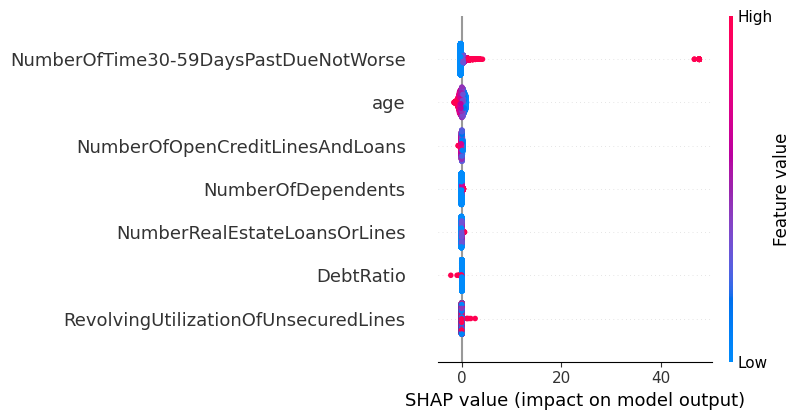

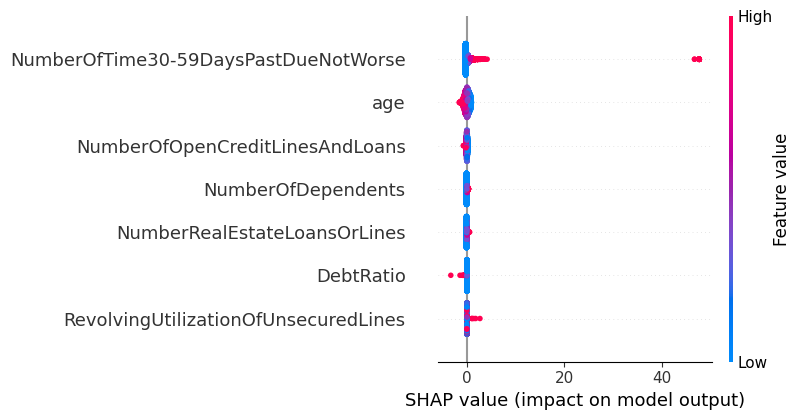

In [388]:
print("Comparison between SHAP values of base and stress cases")
import shap
explainer_base=shap.Explainer(model,X_test)
explainer_stress=shap.Explainer(model,X_test_stresstest)
shapvalues_base=explainer_base(X_test)
shapvalues_stress=explainer_stress(X_test_stresstest)
shap.summary_plot(shapvalues_base,X_test,feature_names=X_res.columns)
shap.summary_plot(shapvalues_stress,X_test_stresstest,feature_names=X_test_stresstest.columns)

In [393]:
print("Now lets randomly increase or decrease the most significant feature influencing default")
print("- Number Of Times 30-59 Days Past Due by 0.01 unit for each customer")
import matplotlib.pyplot as plt
X_test_stresstest=X_test.copy()
y_test_stresstest=y_test.copy()
X_test_stresstest["DebtRatio"]*=1.5
X_test_stresstest["NumberOfTime30-59DaysPastDueNotWorse"]+=0.01*np.random.randint(1,2,size=X_test_stresstest.shape[0])
ypredstress=model.predict(X_test_stresstest)
ystpredprob=model.predict_proba(X_test_stresstest)[:,1]

# Threshold for classifying default
threshold = 0.5

# Classify predictions under normal and stressed
pred_default_base = (ypredres >= threshold).astype(int)
pred_default_stress = (ystpredprob >= threshold).astype(int)

# Compare how many new defaults occur under stress
total_base_defaults = pred_default_base.sum()
total_stress_defaults = pred_default_stress.sum()
increase_in_defaults = (pred_default_stress > pred_default_base).sum()
decrease_in_defaults = (pred_default_stress < pred_default_base).sum()

print(f"Predicted defaults (base): {total_base_defaults}")
print(f"Predicted defaults (stress): {total_stress_defaults}")
print(f"New defaults due to stress: {increase_in_defaults}")
decrease_in_defaults = (pred_default_stress < pred_default_base).sum()
print("Number of customers who turned from risky to safe = ", decrease_in_defaults)
print("Thus the net increase in the number of risky customers =", increase_in_defaults-decrease_in_defaults)

Now lets randomly increase or decrease the most significant feature influencing default
- Number Of Times 30-59 Days Past Due by 0.01 unit for each customer
Predicted defaults (base): 1931
Predicted defaults (stress): 2019
New defaults due to stress: 90
Number of customers who turned from risky to safe =  2
Thus the net increase in the number of risky customers = 88


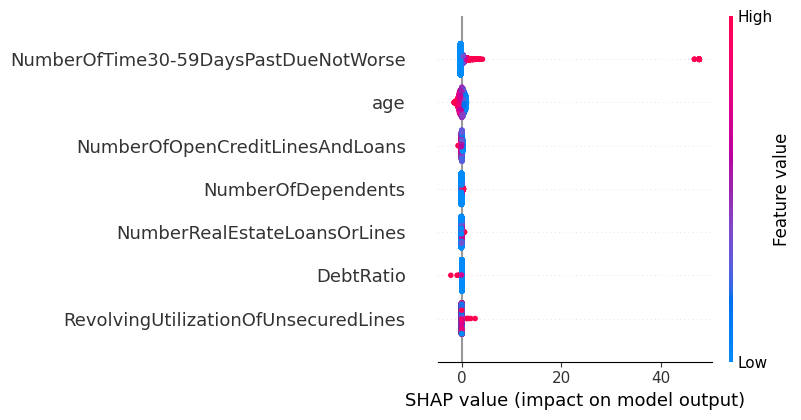

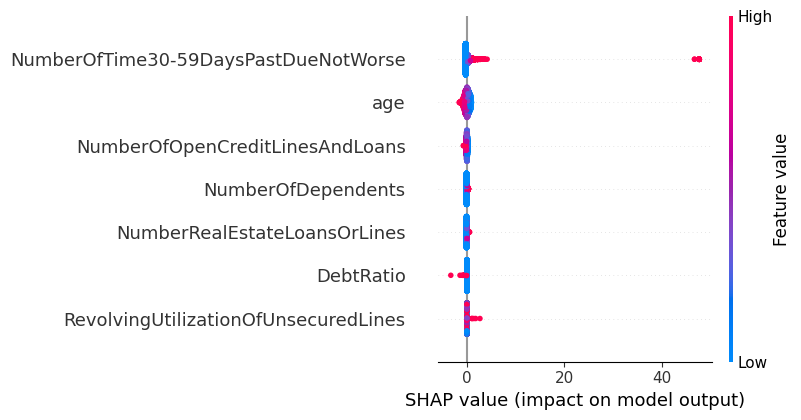

In [391]:
import shap
explainer_base=shap.Explainer(model,X_test)
explainer_stress=shap.Explainer(model,X_test_stresstest)
shapvalues_base=explainer_base(X_test)
shapvalues_stress=explainer_stress(X_test_stresstest)
shap.summary_plot(shapvalues_base,X_test,feature_names=X_test.columns)
shap.summary_plot(shapvalues_stress,X_test_stresstest,feature_names=X_test_stresstest.columns)